## Signal Simulation using ecc_res

#### This notebook is based on the `ecc_res_libstempo.ipynb` by Lankeswar Dey, lanky441@gmail.com. Current version 06/17/2020

This notebook creates a simulated eccentric gravitational wave dataset using `ecc_res` and `libstempo`

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from __future__ import print_function
import sys
import glob
import os
import errno
import numpy as np
import libstempo as T
import libstempo.plot as LP, libstempo.toasim as LT
import ephem
import ecc_res
import json
import scipy.constants as sc

Cannot import PINT? Meh...


In [3]:
T.__version__

'2.3.5'

In [4]:
T.libstempo.tempo2version()

StrictVersion ('2020.7.1')

In [5]:
def get_h0(logmc, log_fgw, logdL):
    Msun = 2e30 #mass of sun in kg
    Mc = 10**logmc*Msun #chirp mass in kg
    fgw = 10**log_fgw #gravitational frequency in Hz
    dL = 10**logdL*3.086e+16 #luminosity distance in meters
    c = sc.speed_of_light
    G = 6.67430e-11 #N⋅m2/kg2
    h0 =  (2*(G*Mc/c**3)**(5/3)*(np.pi*fgw)**(2/3)*c)/dL
    return h0

In [6]:
def get_noise_from_pal2(noisefile):
    psrname = noisefile.split('/')[-1].split('_noise.txt')[0]
    fin = open(noisefile, 'r')
    lines = fin.readlines()
    params = {}
    for line in lines:
        ln = line.split()
        if 'efac' in line:
            par = 'efac'
            flag = ln[0].split('efac-')[-1]
        elif 'equad' in line:
            par = 'log10_equad'
            flag = ln[0].split('equad-')[-1]
        elif 'jitter_q' in line:
            par = 'log10_ecorr'
            flag = ln[0].split('jitter_q-')[-1]
        elif 'RN-Amplitude' in line:
            par = 'red_noise_log10_A'
            flag = ''
        elif 'RN-spectral-index' in line:
            par = 'red_noise_gamma'
            flag = ''
        else:
            break
        if flag:
            name = [psrname, flag, par]
        else:
            name = [psrname, par]
        pname = '_'.join(name)
        params.update({pname: float(ln[1])})
    return params

In [7]:
#Specify the data directory path that contains the parfiles and timfiles
datadir = '/home/bcheeseboro/nanograv_proj/enterprise_proj/ecc_signal_create/small_pta'
noisepath = datadir+'_noise'

In [8]:
#Grab all parfiles and timfiles
parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))
noisefiles = sorted(glob.glob(noisepath+'/*.txt'))

In [9]:
psrlist = ['B1855+09',
           'J0030+0451',
           'J0613-0200',
           'J1012+5307',
           'J1024-0719',
           'J1455-3330',
           'J1600-3053',
           'J1640+2224',
           'J1744-1134',
           'J1909-3744']

In [10]:
#Creates a list of tempo pulsar objects
psrs = []
for par, tim in zip(parfiles, timfiles): #specified 10 for now but this can be changed later
    psr = T.tempopulsar(parfile = par, timfile = tim)
    psrs.append(psr)
    


In [11]:
noise_params = {}
for nf in noisefiles:
    noise_params.update(get_noise_from_pal2(nf))

In [12]:
with open('/home/bcheeseboro/nanograv_proj/enterprise_proj/ecc_signal_create/ecc_sim_code/pulsar_distances.json', 'r') as pdist_file:
    pdist_dict = json.load(pdist_file)

In [13]:
pdists = []
for psr in psrlist:
    if psr in pdist_dict.keys():
         pdists.append(pdist_dict[psr][0])

In [14]:
#Now parse this large dictionary so that we can call noise parameters as noise_dict[pulsar name][noise type]
#Returns either floats or 2 column arrays of flags and values.
#Only pulling efac values for right now.
noise_dict = {}
for psr in psrs:
    noise_dict[psr.name]={}
    noise_dict[psr.name]['efacs'] = []
    for ky in list(noise_params.keys()):
        if psr.name in ky:
            if 'efac' in ky:
                noise_dict[psr.name]['efacs'].append([ky.replace(psr.name + '_' , ''), noise_params[ky]])
    noise_dict[psr.name]['efacs'] = np.array(noise_dict[psr.name]['efacs'])  

In [15]:
for psr in psrs:
    fac = 180./np.pi
    coords = ephem.Equatorial(ephem.Ecliptic(str(psr['ELONG'].val*fac), 
                                                 str(psr['ELAT'].val*fac)))
    ptheta = np.pi/2 - float(repr(coords.dec))
    pphi = float(repr(coords.ra))
    print(pphi, ptheta)

4.963744777775107 1.401125302119396
0.13289428609377968 1.4859553086301012
1.630717539277309 1.605931721194001
2.672785659928814 0.6437244598047221
2.7255255788301755 1.6985911792887745
3.9086626067593975 2.1557066324933785
4.192564649967244 2.1100518127977534
4.3645408902627345 1.1797999580075138
4.644714459548831 1.7729381503009418
5.016907736998348 2.229437960711138


In [16]:
#signal injection parameters
#gw postion
gwphi = 5.02
gwtheta = 2.51
log10_dist = 6

#orbital parameters
q = 1
log10_mc = 9.5
log10_forb = -8.5
e0 = 0.01
l0 = 0
gamma0 = 0
inc = np.pi/3
psi = 0

In [17]:
get_h0(log10_mc, log10_forb, log10_dist)

8.807325411814584e-13

In [18]:
#Designate an output directory for the simulated data files
outdir = '/home/bcheeseboro/nanograv_proj/enterprise_proj/ecc_signal_create/ecc_sim_data/fixed_coords/correct_dist/efac_added/logmc_9.5/source4/'

In [19]:
#creates the output directory if it does not already exist
if not os.path.exists(os.path.dirname(outdir)):
    try:
        os.makedirs(os.path.dirname(outdir))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [20]:
seed_efac = 1234

In [21]:
for i, psr in enumerate(psrs):
    #make the pulsar residuals flat
    LT.make_ideal(psr)
    
    # add efacs
    LT.add_efac(psr, efac = noise_dict[psr.name]['efacs'][:,1], 
                flagid = 'f', flags = noise_dict[psr.name]['efacs'][:,0], 
                seed = seed_efac + np.random.randint(len(psrs)))
    
    #convert pulsar sky location to proper frame
    fac = 180./np.pi
    coords = ephem.Equatorial(ephem.Ecliptic(str(psr['ELONG'].val*fac), 
                                                 str(psr['ELAT'].val*fac)))
    ptheta = np.pi/2 - float(repr(coords.dec))
    pphi = float(repr(coords.ra))
    #Inject signal into set of pulsars
    pdist = pdists[i] #distance of pulsar in kpc
    toas = np.double(psr.toas())*86400 #toas

    residuals = ecc_res.add_ecc_cgw(toas, ptheta, pphi, pdist, gwtheta, gwphi, log10_mc, q, log10_forb, e0, l0, gamma0, 
                    inc, psi, log10_dist, pphase = None, gamma_P = None, tref = 60676, #tref must be greater than the last TOA MJd value
                    psrterm = True, evol = True, waveform_cal = True, res = 'Both')
    psr.stoas[:] += (residuals)/86400 #converting to days
    psr.savepar(outdir + psr.name + '_simulate.par') #saves the simulated par file w/ ecc signal
    psr.savetim(outdir + psr.name + '_simulate.tim') #saves the simulated tim file w/ ecc signal

In [22]:
inj_params = {'gwphi': gwphi, 'gwtheta': gwtheta, 'log10_dist': log10_dist, 'q': q, 'log10_mc': log10_mc, 'log10_forb': log10_forb, 'e0': e0, 'l0': l0, 'gamma0': gamma0, 'inc': inc, 'psi': psi}

In [23]:
#save injection parameters as a dictionary
ecc_dict_dump = json.dumps(inj_params)
f = open(outdir+"ecc_inj_params.json","w")
f.write(ecc_dict_dump)
f.close()

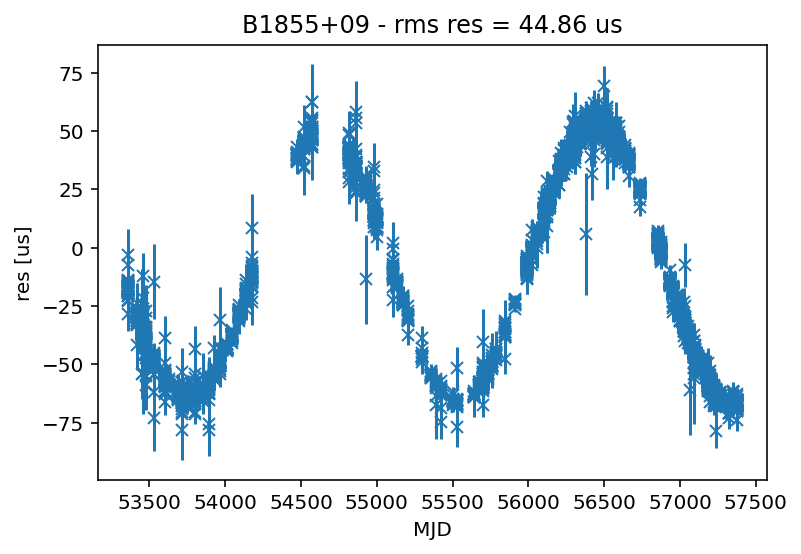

In [24]:
LP.plotres(psrs[0])